# UZOP Projekt na temu rada "Early Predictor for Student Success Based on Behavioural and Demographical Indicators "

### Vrste istraživanja prema:
a) Svrsi - Primjenjeno istraživanje jer je primjenjeno na stvaran problem

b) Izvoru informacije - Sekundarno istraživanje

c) Vemenu provedbe - Studija presjeka

d) Načinu prikupljanja podataka - Dokumentarno istraživanje

e) Vrsti korištenih podataka - Kvantitativno istraživanje jer koristi mjerljive varijable

f) Stupnju manipulacije varijablama - Promatračko istraživanje

g) Dubini - Korelacijsko istraživanje jer identificira odnos varijabe rezultata studenta i ostalih varijabli

h) Vrsti zaključka - Hipotetičko-deduktivno istraživanje

### Metode prikupljanja podataka za članak 
Dokumentarno istraživanje

### Podaci su prikupljeni i objavljeni prema pravilima istraživačke etike

### Učitavanje osnovnih biblioteka

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
#from bartpy.sklearnmodel import SklearnModel # Ne radi
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score

from tqdm import tqdm

### Učitavanje podataka

In [2]:
assessments = pd.read_csv("data/assessments.csv")
courses = pd.read_csv("data/courses.csv")
studentAssessment = pd.read_csv("data/studentAssessment.csv")
studentInfo = pd.read_csv("data/studentInfo.csv")
studentRegistration = pd.read_csv("data/studentRegistration.csv")
studentVle = pd.read_csv("data/studentVle.csv")
vle = pd.read_csv("data/vle.csv")

## 3. Metode

### 3.1 Podaci

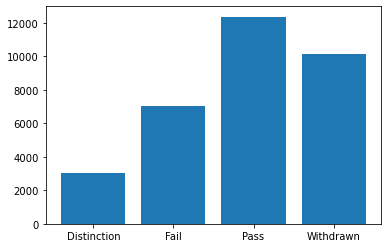

In [3]:
count_per_final_result = studentInfo.groupby('final_result').count().loc[:,'id_student'].values
final_result = studentInfo.groupby('final_result').count().index.values

plt.bar(final_result, count_per_final_result)
plt.show()

### 3.2 Priprema podataka

In [4]:
def get_first_assessment_for_course_and_code_presentation(assesments_for_course, code_presentation):
    assesments_for_code_presentation = assesments_for_course.dropna(subset=['date'])
    assesments_for_code_presentation = assesments_for_code_presentation.loc[assesments_for_code_presentation['code_presentation'] == code_presentation]
    assesments_for_code_presentation = assesments_for_code_presentation.sort_values(by=['date'], ascending=True)
    assesments_for_code_presentation['index'] = range(len(assesments_for_code_presentation))
    assesments_for_code_presentation = assesments_for_code_presentation.set_index('index')
    assesments_for_code_presentation = assesments_for_code_presentation.loc[assesments_for_code_presentation['date'] == assesments_for_code_presentation.loc[0]['date']]
    return assesments_for_code_presentation

In [5]:
def get_first_assessments_for_course(course):
    assesments_for_course = assessments.loc[assessments['code_module'] == course]
    new_data_frame = pd.DataFrame(columns=['course', 'code_presentation', 'id_assessment', 'date'])
    i = 0
    for code_presentation in assesments_for_course.groupby('code_presentation').count().index.values:
        for index, row in get_first_assessment_for_course_and_code_presentation(assesments_for_course, code_presentation).iterrows():
            new_data_frame.loc[i] = (course, row['code_presentation'], row['id_assessment'], row['date'])
            i += 1
    return new_data_frame

In [6]:
def get_number_of_students_for_assessment(id_assessment):
    return len(studentAssessment.loc[studentAssessment['id_assessment'] == id_assessment])

In [7]:
def get_number_of_students_by_course(course):
    return len(studentInfo.loc[studentInfo['code_module'] == course])

### Stvaranje tablice "Information about MOOCs"

In [8]:
course_with_first_assessments = pd.DataFrame(columns=['Course', '1st assignment submission day', '# of registered students', 'Year(run)'])

In [9]:
courses_names = assessments.groupby('code_module').count().index.values

first_assessments_ids_dict = {}

i = 0
for course_name in courses_names:
    course_data_frame = get_first_assessments_for_course(course_name)
    
    first_assessments_ids_dict[course_name] = course_data_frame['id_assessment'].to_list()
    
    # Stvarni broj studenata koji su pristupili zadacima
    sum_of_students = 0
    best_date = 100000
    year_set = set()
    for index, row in course_data_frame.iterrows():
        sum_of_students += get_number_of_students_for_assessment(row['id_assessment'])
        date = row['date']
        year_set.add(row['code_presentation'][0:4])
        best_date = min(best_date, date)
    year = ""
    for y in year_set:
        year += y + " & "
    year = year[:-3]
    
    sum_of_students_by_course = get_number_of_students_by_course(course_name)
    
    course_with_first_assessments.loc[i] = (course_name, "Day " + str(int(best_date)), sum_of_students_by_course, year)
    i += 1

In [10]:
# BBB i DDD su različiti od rezultata u radu
course_with_first_assessments

,Course,1st assignment submission day,# of registered students,Year(run)
0,AAA,Day 19,748,2013 & 2014
1,BBB,Day 12,7909,2013 & 2014
2,CCC,Day 18,4434,2014
3,DDD,Day 20,6272,2013 & 2014
4,EEE,Day 33,2934,2013 & 2014
5,FFF,Day 19,7762,2013 & 2014
6,GGG,Day 61,2534,2013 & 2014


In [11]:
def get_first_date_of_assessment_of_course_for_all_students(course):
    students_in_course = studentInfo.loc[studentInfo['code_module'] == course]['id_student'].to_list()
    date = -1
    id_assessment = -1
    s_id = -1
    for id_student in students_in_course:
        filtered = studentAssessment.loc[studentAssessment['id_student'] == id_student].sort_values(by=['date_submitted'], ascending=True)
        for index, row in filtered.iterrows():
            if row['date_submitted'] > date:
                date = row['date_submitted'] 
                id_assessment = row['id_assessment'] 
                s_id = row['id_student'] 
            break
    return date, id_assessment, s_id

## 3.3 Analiza

In [12]:
def get_score_of_students_first_assessment(id_student, first_assessments_ids_dict):
    code_name = studentInfo[studentInfo['id_student'] == id_student]['code_module'].iloc[0]
    first_assessments_ids = first_assessments_ids_dict[code_name]
    for first_assessments_id in first_assessments_ids:
        h_d = studentAssessment.loc[(studentAssessment['id_student'] == id_student) & (studentAssessment['id_assessment'] == first_assessments_id)]
        if len(h_d) > 0:
            return h_d['score'].iloc[0]
    return 0

In [14]:
def get_clicks_of_student_till_course_starts(id_student):
    return studentVle.loc[(studentVle['id_student'] == id_student) & (studentVle['date'] < 0)]['sum_click'].sum()

In [15]:
def get_registration_date(id_student):
    try:
        return int(studentRegistration.loc[studentRegistration['id_student'] == id_student]['date_registration'].to_list()[0])
    except:
        return studentRegistration.loc[studentRegistration['id_student'] == id_student]['date_registration'].to_list()[0]

### Stvaranje dataframe-a "analysis"

In [18]:
analysis_data_frame = pd.DataFrame(columns=['First Assignment Mark', 'Educational Level', 'Clicks till Course Starts', 'Registration Date', 'Age', 'Disability', 'Gender', 'Previous Attempts', 'Withdrawn', 'Fail', 'Pass', 'Distinction'])

In [19]:
i = 0

with tqdm(total = len(studentInfo)) as bar:
    for index, row in studentInfo.iterrows():
        id_student = row['id_student']

        score = get_score_of_students_first_assessment(id_student, first_assessments_ids_dict)
        education_level = row['highest_education']
        clicks = get_clicks_of_student_till_course_starts(id_student)
        reg_date = get_registration_date(id_student)
        age = row['age_band']
        disability = row['disability']
        gender = row['gender']
        num_of_prev_attempts = row['num_of_prev_attempts']
        withdrawn = 1 if row['final_result'] == 'Withdrawn' else 0
        fail = 1 if row['final_result'] == 'Fail' else 0
        pass_v = 1 if row['final_result'] == 'Pass' else 0
        distinction = 1 if row['final_result'] == 'Distinction' else 0

        # Dodavanje reda u dataframe
        analysis_data_frame.loc[i] = (score, education_level, clicks, reg_date, age, disability, gender, num_of_prev_attempts, withdrawn, fail, pass_v, distinction)
        i += 1
        bar.update(1)

100%|██████████| 32593/32593 [24:22<00:00, 22.28it/s]


In [20]:
analysis_data_frame

,First Assignment Mark,Educational Level,Clicks till Course Starts,Registration Date,Age,Disability,Gender,Previous Attempts,Withdrawn,Fail,Pass,Distinction
0,78.0,HE Qualification,98,-159,55<=,N,M,0,0,0,1,0
1,70.0,HE Qualification,215,-53,35-55,N,F,0,0,0,1,0
2,0.0,A Level or Equivalent,102,-92,35-55,Y,F,0,1,0,0,0
3,72.0,A Level or Equivalent,169,-52,35-55,N,F,0,0,0,1,0
4,69.0,Lower Than A Level,295,-176,0-35,N,F,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,0.0,Lower Than A Level,2,-4,0-35,N,F,0,0,1,0,0
32589,80.0,Lower Than A Level,0,-23,35-55,N,F,0,0,0,0,1
32590,65.0,A Level or Equivalent,15,-129,0-35,Y,F,0,0,0,1,0
32591,83.0,Lower Than A Level,65,-49,35-55,N,F,0,1,0,0,0


### Stvaranje tablice "Pearson’s Correlation test result"

In [21]:
def calc_coef(column_1, column_2, dataframe = analysis_data_frame):
    cleared_analysis_data_frame = dataframe
    cleared_analysis_data_frame = cleared_analysis_data_frame.dropna(subset = [column_1, column_2])
    return stats.pearsonr(cleared_analysis_data_frame[column_1], cleared_analysis_data_frame[column_2])

In [22]:
def calc_coef_table(names, dataframe):
    table = pd.DataFrame(columns=names)
    for name1 in names:
        values = np.array([])
        for name2 in names:
            values = np.append(values,round(calc_coef(name1, name2, dataframe)[0],2))
        table.loc[name1] = values
    return table

In [23]:
# Transformacija podataka
# Vrijednosti varijable Educational Level se tranformiraju u 0 za skup {No Formal Quals, Lower Than A Level}, te u 1 za skup {A Level or Equivalent, HE Qualification, Post Graduate Qualification}
tranformed_analysis_data_frame = analysis_data_frame.copy()

# Vrijednosti varijable Disability se tranformiraju u 1 za Y, te u 0 za N
tranformed_analysis_data_frame['Disability'] = np.where(tranformed_analysis_data_frame['Disability'] == 'N', 0, tranformed_analysis_data_frame['Disability'])
tranformed_analysis_data_frame['Disability'] = np.where(tranformed_analysis_data_frame['Disability'] == 'Y', 1, tranformed_analysis_data_frame['Disability'])

# Vrijednosti varijable Gender se tranformiraju u 0 za M, te u 1 za F
tranformed_analysis_data_frame['Gender'] = np.where(tranformed_analysis_data_frame['Gender'] == 'F', 1, tranformed_analysis_data_frame['Gender'])
tranformed_analysis_data_frame['Gender'] = np.where(tranformed_analysis_data_frame['Gender'] == 'M', 0, tranformed_analysis_data_frame['Gender'])

# Vrijednosti varijable Age se tranformiraju u 0 za 0-35, te u 1 za 35<=
tranformed_analysis_data_frame['Age'] = np.where(tranformed_analysis_data_frame['Age'] != '0-35', 1, tranformed_analysis_data_frame['Age'])
tranformed_analysis_data_frame['Age'] = np.where(tranformed_analysis_data_frame['Age'] == '0-35', 0, tranformed_analysis_data_frame['Age'])

# Vrijednosti varijable Educational Level se tranformiraju u 0 za skup {No Formal Quals, Lower Than A Level}, te u 1 za skup {A Level or Equivalent, HE Qualification, Post Graduate Qualification}
tranformed_analysis_data_frame['Educational Level'] = np.where(tranformed_analysis_data_frame['Educational Level'] == 'A Level or Equivalent', 1, tranformed_analysis_data_frame['Educational Level'])
tranformed_analysis_data_frame['Educational Level'] = np.where(tranformed_analysis_data_frame['Educational Level'] == 'HE Qualification', 1, tranformed_analysis_data_frame['Educational Level'])
tranformed_analysis_data_frame['Educational Level'] = np.where(tranformed_analysis_data_frame['Educational Level'] == 'Post Graduate Qualification', 1, tranformed_analysis_data_frame['Educational Level'])


tranformed_analysis_data_frame['Educational Level'] = np.where(tranformed_analysis_data_frame['Educational Level'] == 'No Formal quals', 0, tranformed_analysis_data_frame['Educational Level'])
tranformed_analysis_data_frame['Educational Level'] = np.where(tranformed_analysis_data_frame['Educational Level'] == 'Lower Than A Level', 0, tranformed_analysis_data_frame['Educational Level'])


In [24]:
tranformed_analysis_data_frame

,First Assignment Mark,Educational Level,Clicks till Course Starts,Registration Date,Age,Disability,Gender,Previous Attempts,Withdrawn,Fail,Pass,Distinction
0,78.0,1,98,-159,1,0,0,0,0,0,1,0
1,70.0,1,215,-53,1,0,1,0,0,0,1,0
2,0.0,1,102,-92,1,1,1,0,1,0,0,0
3,72.0,1,169,-52,1,0,1,0,0,0,1,0
4,69.0,0,295,-176,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,0.0,0,2,-4,0,0,1,0,0,1,0,0
32589,80.0,0,0,-23,1,0,1,0,0,0,0,1
32590,65.0,1,15,-129,0,1,1,0,0,0,1,0
32591,83.0,0,65,-49,1,0,1,0,1,0,0,0


In [25]:
names = ['Gender', 'Educational Level', 'Age', 'Previous Attempts', 'Disability', 'First Assignment Mark', 'Registration Date', 'Clicks till Course Starts']
table = calc_coef_table(names, tranformed_analysis_data_frame)

### Pearson’s Correlation test result

In [26]:
table

,Gender,Educational Level,Age,Previous Attempts,Disability,First Assignment Mark,Registration Date,Clicks till Course Starts
Gender,1.00,-0.05,0.03,0.03,0.04,-0.03,0.03,-0.10
Educational Level,-0.05,1.00,0.01,-0.04,-0.05,0.12,0.01,0.05
Age,0.03,0.01,1.00,0.01,-0.02,0.05,0.04,0.11
Previous Attempts,0.03,-0.04,0.01,1.00,0.05,-0.03,-0.03,-0.01
Disability,0.04,-0.05,-0.02,0.05,1.00,-0.04,-0.01,0.01
First Assignment Mark,-0.03,0.12,0.05,-0.03,-0.04,1.00,0.11,0.21
Registration Date,0.03,0.01,0.04,-0.03,-0.01,0.11,1.00,-0.08
Clicks till Course Starts,-0.10,0.05,0.11,-0.01,0.01,0.21,-0.08,1.00


## 4. Decision Tree and Random Forest

In [29]:
# Čišćenje podataka
tranformed_analysis_data_frame_cleared = tranformed_analysis_data_frame.dropna()

In [30]:
columns = ['Gender', 'Educational Level', 'Age', 'Previous Attempts', 'Disability', 'First Assignment Mark', 'Registration Date', 'Clicks till Course Starts']
X = tranformed_analysis_data_frame_cleared[columns]
y_withdrawn = tranformed_analysis_data_frame_cleared['Withdrawn'].to_list()
y_fail = tranformed_analysis_data_frame_cleared['Fail'].to_list()
y_pass = tranformed_analysis_data_frame_cleared['Pass'].to_list()
y_distinction = tranformed_analysis_data_frame_cleared['Distinction'].to_list()

# Podjela podataka na skup za treniranje i testiranje
X_train_withdrawn  , X_test_withdrawn  , y_train_withdrawn  , y_test_withdrawn   = train_test_split(X, y_withdrawn  , test_size=0.3, random_state=1)
X_train_fail       , X_test_fail       , y_train_fail       , y_test_fail        = train_test_split(X, y_fail       , test_size=0.3, random_state=1)
X_train_pass       , X_test_pass       , y_train_pass       , y_test_pass        = train_test_split(X, y_pass       , test_size=0.3, random_state=1)
X_train_distinction, X_test_distinction, y_train_distinction, y_test_distinction = train_test_split(X, y_distinction, test_size=0.3, random_state=1)

In [31]:
X_train_dict = {'Withdrawn': X_train_withdrawn, 'Fail': X_train_fail, 'Pass': X_train_pass, 'Distinction': X_train_distinction}
X_test_dict  = {'Withdrawn': X_test_withdrawn , 'Fail': X_test_fail , 'Pass': X_test_pass , 'Distinction': X_test_distinction }
y_train_dict = {'Withdrawn': y_train_withdrawn, 'Fail': y_train_fail, 'Pass': y_train_pass, 'Distinction': y_train_distinction}
y_test_dict  = {'Withdrawn': y_test_withdrawn , 'Fail': y_test_fail , 'Pass': y_test_pass , 'Distinction': y_test_distinction }

In [32]:
clf_withdrawn   = DecisionTreeClassifier().fit(X_train_withdrawn  , y_train_withdrawn)
clf_fail        = DecisionTreeClassifier().fit(X_train_fail       , y_train_fail)
clf_pass        = DecisionTreeClassifier().fit(X_train_pass       , y_train_pass)
clf_distinction = DecisionTreeClassifier().fit(X_train_distinction, y_train_distinction)

In [33]:
table_alg = pd.DataFrame(columns=['Result', 'Metric', 'Decision Tree', 'Random Forest', 'Bart'])

In [34]:
i = 0

with tqdm(total = 4) as bar:
    for result in ['Withdrawn', 'Fail', 'Pass', 'Distinction']:
        X_train = X_train_dict[result]
        X_test  = X_test_dict[result]
        y_train = y_train_dict[result]
        y_test  = y_test_dict[result]

        clf_decision_tree = DecisionTreeClassifier().fit(X_train, y_train)
        clf_random_forest = RandomForestClassifier().fit(X_train, y_train)
        #clf_bart          = SklearnModel().fit(X_train, y_train)

        y_predicted_decision_tree = clf_decision_tree.predict(X_test)
        y_predicted_random_forest = clf_random_forest.predict(X_test)
        #y_predicted_bart          = clf_bart.predict(X_test)

        table_alg.loc[i] = (result, 'Precision', precision_score(y_test, y_predicted_decision_tree), precision_score(y_test, y_predicted_random_forest), 0)
        i += 1
        table_alg.loc[i] = (result, 'Recall ', recall_score(y_test, y_predicted_decision_tree), recall_score(y_test, y_predicted_random_forest), 0)
        i += 1
        table_alg.loc[i] = (result, 'F1', f1_score(y_test, y_predicted_decision_tree) , f1_score(y_test, y_predicted_random_forest), 0)
        i += 1
        table_alg.loc[i] = (result, 'Accuracy', accuracy_score(y_test, y_predicted_decision_tree), accuracy_score(y_test, y_predicted_random_forest), 0)
        i += 1

        if result != 'Distinction':
            table_alg.loc[i] = ('---------', '---------', '---------' ,'---------', '---------')
            i += 1
            
        bar.update(1)



100%|██████████| 4/4 [00:08<00:00,  2.06s/it]


#### Results

In [35]:
table_alg

,Result,Metric,Decision Tree,Random Forest,Bart
0,Withdrawn,Precision,0.499351,0.654618,0
1,Withdrawn,Recall,0.503932,0.480668,0
2,Withdrawn,F1,0.501631,0.554317,0
3,Withdrawn,Accuracy,0.686693,0.758151,0
4,---------,---------,---------,---------,---------
5,Fail,Precision,0.277081,0.341693,0
6,Fail,Recall,0.302542,0.159824,0
7,Fail,F1,0.289252,0.217782,0
8,Fail,Accuracy,0.688128,0.759176,0
9,---------,---------,---------,---------,---------
